# Camera calibration

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg


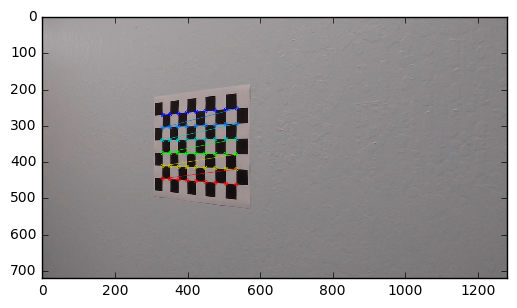

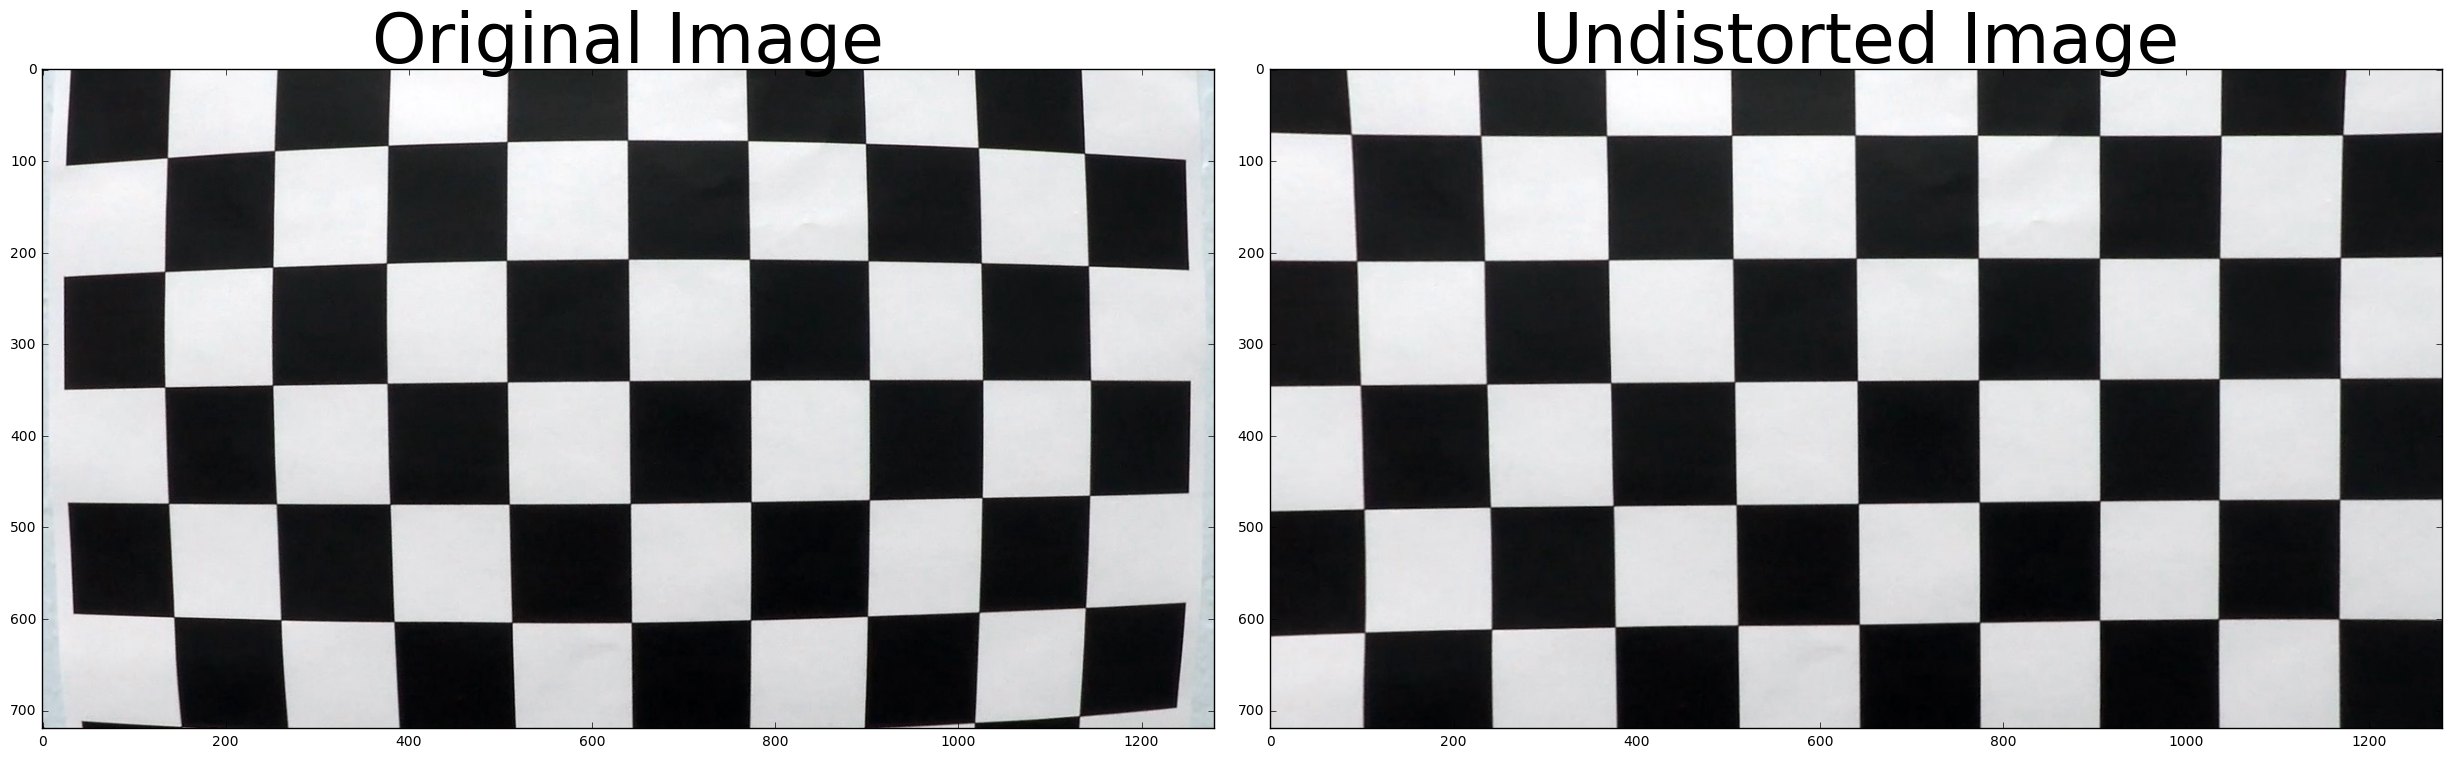

In [263]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images_filenames = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
show_corners_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration7.jpg'
calibration_images_filenames.remove(test_image_filename)

inside_corners_count_x = 9
inside_corners_count_y = 6

objp = np.zeros((inside_corners_count_x * inside_corners_count_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:inside_corners_count_x, 0:inside_corners_count_y].T.reshape(-1,2)

corners_res = []
objp_res = []

detection_failed_count = 0

for calibration_image_filename in calibration_images_filenames:
    img = cv2.imread(calibration_image_filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (inside_corners_count_x, inside_corners_count_y), None)
    
    if ret:
        corners_res.append(corners)
        objp_res.append(objp)
    else:
        print('Chessboard corner detection failed:', calibration_image_filename)
            
    if show_corners_image_filename == calibration_image_filename:
        img_corners = cv2.drawChessboardCorners(img, (inside_corners_count_x, inside_corners_count_y), corners, ret)
        plt.imshow(img_corners)

test_img = cv2.imread(test_image_filename)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_res, corners_res, test_img.shape[0:2], None, None)

def undistort(image):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undistorted_img

undistorted_img = undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binay Image

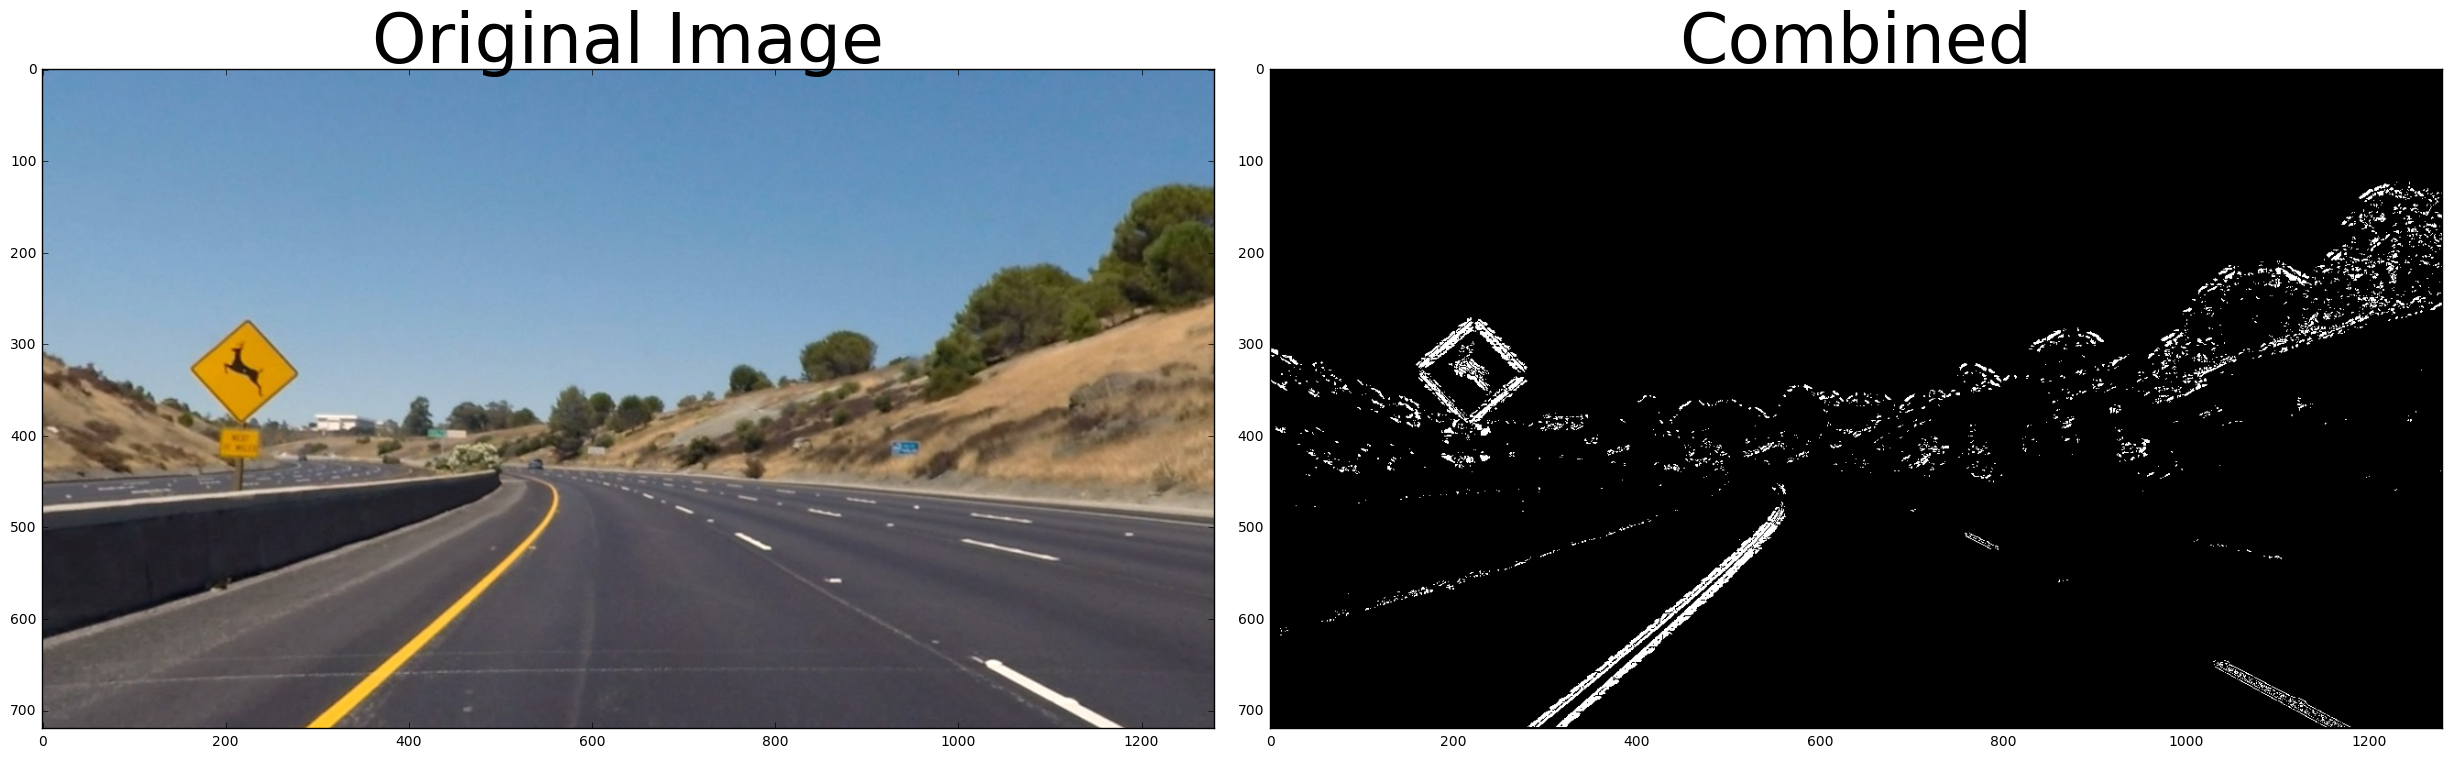

In [429]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(pow(sobel_x, 2) + pow(sobel_y, 2))
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 6) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def hls_select(S, thresh=(0, 255)):
    # 1) Equalize histogram for S changel
    #eq_S = cv2.equalizeHist(S)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(S, thresh=(90, 255))

    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
    #combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary == 1)] = 1
    #combined[(hls_binary == 1)] = 1
    
    return combined

# Read in an image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

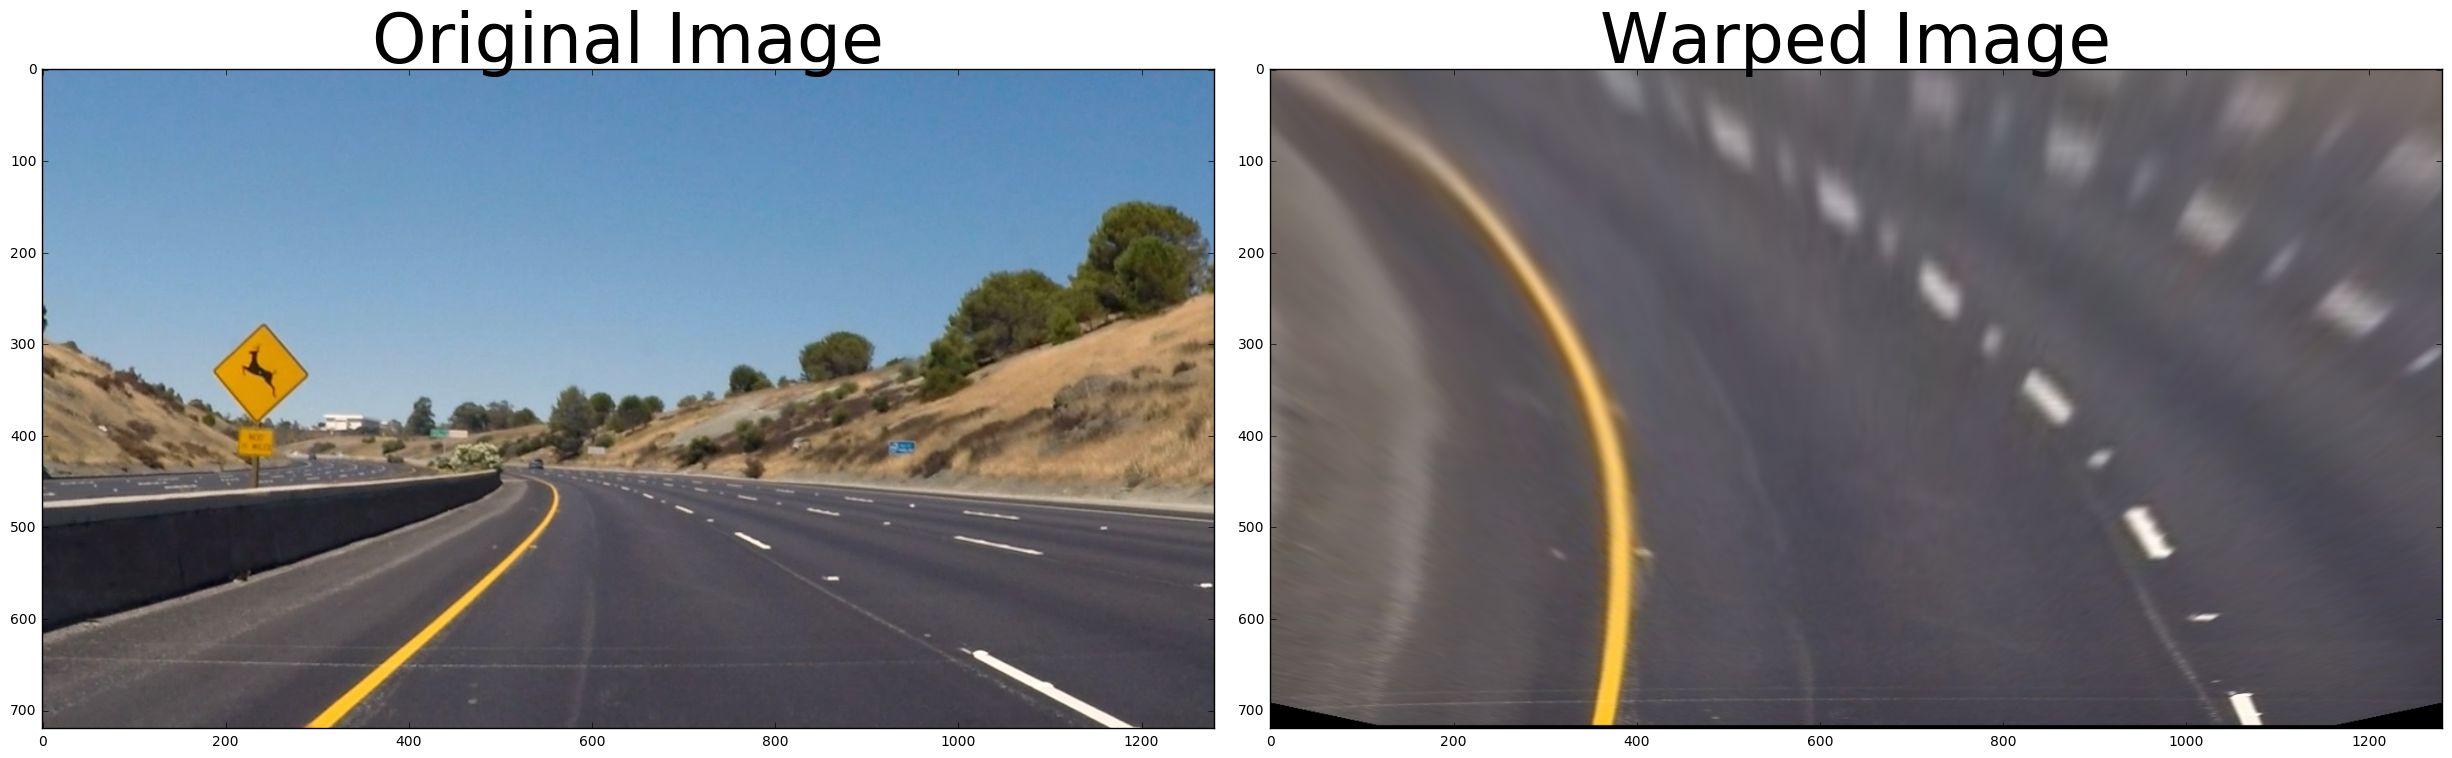

In [430]:
def change_prespective(image, reverse = False):
    src = np.float32([
            [image.shape[1]*0.45, image.shape[0]*0.625],
            [image.shape[1]*0.55, image.shape[0]*0.625],
            [image.shape[1]*0.175, image.shape[0]*0.95],
            [image.shape[1]*0.825, image.shape[0]*0.95],
        ])

    dst = np.float32([
            [image.shape[1]*0.2,image.shape[0]*0.025],
            [image.shape[1]*0.8,image.shape[0]*0.025],
            [image.shape[1]*0.2,image.shape[0]*0.975],
            [image.shape[1]*0.8,image.shape[0]*0.975],
        ])
    
    if (reverse):
        src, dst = dst, src

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

    return warped

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = change_prespective(undistorted_img)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding the lanes

Left curvature: 22324.1667024 m
Right curvature: 2743.49788194 m
Distance from center: 0.0500600215261 m


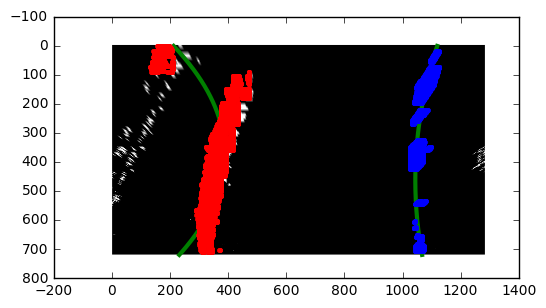

In [491]:
from scipy import signal

# Retuns list of tuples with peak position and peak value, sorted by value
def get_peaks(image):
    histogram = np.sum(image, axis=0)
    peak_indexes = signal.find_peaks_cwt(histogram, np.arange(1, image.shape[1]))
    peak_values = [histogram[index] for index in peak_indexes]
    peak_indexes_to_values = {(index, histogram[index]) for index in peak_indexes}
    result = sorted(peak_indexes_to_values, key=lambda index_to_value:index_to_value[1], reverse=True)    
    return result

# Returns tuple of left and right lane location
def get_lanes(image, verbose=False):
    image_width = image.shape[1]
    image_height = image.shape[0]
    left_start = 0
    left_end = image_width // 2
    right_start = image_width // 2
    right_end = image_width
    
    piece_left = image[:, left_start:left_end]
    piece_right = image[:, right_start:right_end]

    left_peaks = get_peaks(piece_left)
    right_peaks = get_peaks(piece_right)
    
    left_lane_x = None
    right_lane_x = None

    if len(left_peaks) > 0:
        left_lane_x = left_start + left_peaks[0][0]

    if len(right_peaks) > 0:
        right_lane_x = right_start + right_peaks[0][0]
        
    if verbose:
        histogram = np.sum(image, axis=0)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(image, cmap='gray')
        ax.plot(histogram, color='red')
        if left_lane_x != None:
            ax.plot([left_lane_x, left_lane_x], [0, image_height], color='green', linestyle='-', linewidth=2)
        if right_lane_x != None:
            ax.plot([right_lane_x, right_lane_x], [0, image_height], color='green', linestyle='-', linewidth=2)
            
    return (left_lane_x, right_lane_x)

def get_points_around_x(image, lane_x, low_y):
    image_width = image.shape[1]
    sub_piece_diff = 50
    
    low_x = max(0, lane_x - sub_piece_diff)
    high_x = min(image_width, lane_x + sub_piece_diff)
        
    sub_piece = image[:, low_x:high_x]
    coordinates = np.nonzero(sub_piece)
    coordinates = [coordinates[0] + low_y, coordinates[1] + low_x]
        
    return coordinates

def get_lane_points(image, verbose=False):
    pieces_desired = 8
    image_height = image.shape[0]
    piece_height = image_height//pieces_desired
    
    left_lane_coordinates = [[],[]]
    right_lane_coordinates = [[],[]]

    for i in range(0, pieces_desired):
        low_y = piece_height * i
        high_y = piece_height * (i + 1)

        piece = image[low_y:high_y, :]
        
        lanes = get_lanes(piece, verbose)
                        
        if lanes[0] != None:            
            coordinates = get_points_around_x(piece, lanes[0], low_y)
            left_lane_coordinates[0].extend(coordinates[0])
            left_lane_coordinates[1].extend(coordinates[1])
            
        if lanes[1] != None:
            coordinates = get_points_around_x(piece, lanes[1], low_y)
            right_lane_coordinates[0].extend(coordinates[0])
            right_lane_coordinates[1].extend(coordinates[1])

    left_lane_coordinates = np.array(left_lane_coordinates)
    right_lane_coordinates = np.array(right_lane_coordinates)
        
    return left_lane_coordinates, right_lane_coordinates

def fit_line(line_x, line_y):
    return np.polyfit(line_y, line_x, 2)
    
def get_x_for_line(line_fit, line_y):
    return line_fit[0]*line_y**2 + line_fit[1]*line_y + line_fit[2]

def get_curvature(line_fit, y_eval):
    return ((1 + (2*line_fit[0]*y_eval + line_fit[1])**2)**1.5) \
                             /np.absolute(2*line_fit[0])

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test1.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = change_prespective(combined)

left_lane_coordinates, right_lane_coordinates = get_lane_points(warped, verbose=False)
    
left_fit = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
right_fit = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])

y_vals = np.arange(0, raw_test_image.shape[0])

left_fitx = get_x_for_line(left_fit, y_vals)
right_fitx = get_x_for_line(right_fit, y_vals)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(warped, cmap='gray')
ax.plot(left_fitx, y_vals, color='green', linewidth=3)
ax.plot(right_fitx, y_vals, color='green', linewidth=3)
ax.plot(left_lane_coordinates[1], left_lane_coordinates[0], '.', color='red')
ax.plot(right_lane_coordinates[1], right_lane_coordinates[0], '.', color='blue')

# Define conversions in x and y from pixels space to meters
lane_width_pix = 700
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/lane_width_pix # meteres per pixel in x dimension

left_fit_cr = fit_line(left_lane_coordinates[1] * xm_per_pix, left_lane_coordinates[0] * ym_per_pix)
right_fit_cr = fit_line(right_lane_coordinates[1] * xm_per_pix, right_lane_coordinates[0] * ym_per_pix)
    
left_curverad = get_curvature(left_fit_cr, y_eval)
right_curverad = get_curvature(right_fit_cr, y_eval)

# Now our radius of curvature is in meters
print("Left curvature:", left_curverad, 'm')
print("Right curvature:", right_curverad, 'm')

left_fitx_bottom_m = get_x_for_line(left_fit_cr, y_eval*ym_per_pix)
right_fitx_bottom_m = get_x_for_line(right_fit_cr, y_eval*ym_per_pix)

center_ideal_m = raw_test_image.shape[1]*xm_per_pix / 2
center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])

distance_from_center = abs(center_ideal_m - center_actual_m)
print("Distance from center:", distance_from_center, 'm')

# Warp lines back to original image

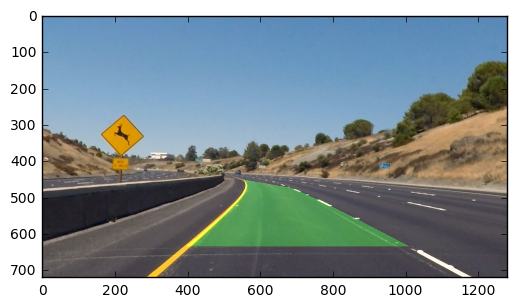

In [483]:
def draw_lane(image):
    undistorted_image = undistort(image)

    combined = get_binary_image(undistorted_image)

    warped = change_prespective(combined)
    
    left_lane_coordinates, right_lane_coordinates = get_lane_points(warped)
    
    left_fit = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])

    left_fitx = get_x_for_line(left_fit, left_lane_y)
    right_fitx = get_x_for_line(right_fit, right_lane_y)

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undistorted_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_lane_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_lane_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = change_prespective(color_warp, reverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    return result

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

result = draw_lane(raw_test_image)
    
plt.imshow(result)

# Video

In [282]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def write_clip(input_file, output_file, function):
    clip = VideoFileClip(input_file)
    white_clip = clip.fl_image(function) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_file, audio=False)  
    
def process_frame(image):
    result = draw_lane(image)
    return result

video_input = '../CarND-Advanced-Lane-Lines/project_video.mp4'
video_output = 'project_video_solution.mp4'

write_clip(video_input, video_output, process_frame)

HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_output))

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [1:04:42<00:03,  3.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 1h 2min 6s, sys: 3min 1s, total: 1h 5min 8s
Wall time: 1h 4min 43s
